In [4]:
from intake import open_catalog
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean
from altimetry_tools import filterSpec
import warnings 
warnings.filterwarnings('ignore')

# pull AVISO ugos, vgos from pangeo
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()

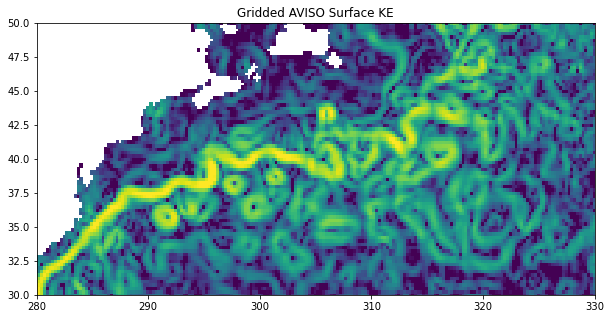

In [6]:
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(ds['longitude'], ds['latitude'], 0.5*(ds['ugos'][1]**2 + ds['vgos'][1]**2), norm=LogNorm(vmin=0.001, vmax=1))
ax.set_title('Gridded AVISO Surface KE')
ax.set_xlim([280, 330])
ax.set_ylim([30, 50])
plt.show()

In [7]:
# function Ian helped construct, will filter to: 
# -- constant factor (0.25->1) 
# -- fixed filter scale (relative to smallest grid step in data)
def Laplacian2D(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field. Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (x, y) whose Laplacian is computed
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, size size as 2nd dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Nx = np.size(field,0)
    Ny = np.size(field,1) # I suppose these could be inputs
    notLand = 1 - landMask
    # first compute Laplacian in y direction. "Right" is north and "Left" is south for this block
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxRight[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    fluxLeft = np.zeros((Nx,Ny))
    fluxLeft[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxLeft[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    OUT = (1/(dy**2))*(fluxRight - fluxLeft)
    # Now compute Laplacian in x direction and add it back in
    fluxRight = 0*fluxRight # re-set to zero just to be safe
    fluxLeft = 0*fluxLeft # re-set to zero just to be safe
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    OUT = OUT + (1/(dx**2))*(fluxRight - fluxLeft)
    return OUT*notLand

In [8]:
# input field with dimensions [time, lat, lon]
def Filter2d(NL,sL,NB,sB,field,dx,dy):  
    # define land mask based on nan bounds of model domain
    Nx = len(field[0, 1, :])
    Ny = len(field[0, :, 1])
    landMask = 0*np.random.randint(0,2,(Nx,Ny))
    landMask[np.isnan(np.transpose(field[0, :, :]))] = 1
    landMask[np.transpose(field[0, :, :] == 0)] = 1
    landMask = np.transpose(landMask)
    wetMask = 1 - landMask
    
    data_out = np.nan * np.ones(np.shape(field))
    for c in range(np.shape(field)[0]):      
        
        data = field[c].copy()
        data = np.nan_to_num(data) 
        data = data * wetMask # Initalize the filtering process
        
        for i in range(NL):
            tempL = Laplacian2D(data, landMask, dx, np.int(dy))        # Laplacian1D(data,landMask,dx)
            data = data + (1/sL[i])*tempL # Update filtered field
        for i in range(NB):
            tempL = Laplacian2D(data, landMask, dx, np.int(dy))        # Laplacian1D(data, landMask, dx)
            tempB = Laplacian2D(tempL, landMask, dx, np.int(dy))       # Laplacian1D(tempL, landMask, dx)
            data = data + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
        data_out[c, :, :] = data  
    
    return(data_out)

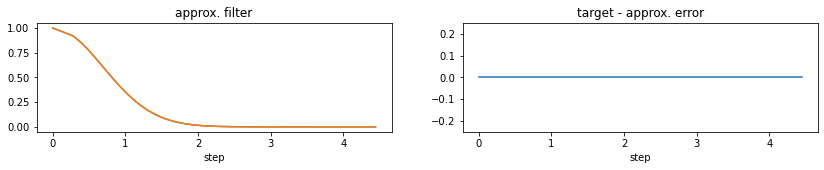

Gaussian, # Laplacian steps: 2; # Biharmonic steps: 9


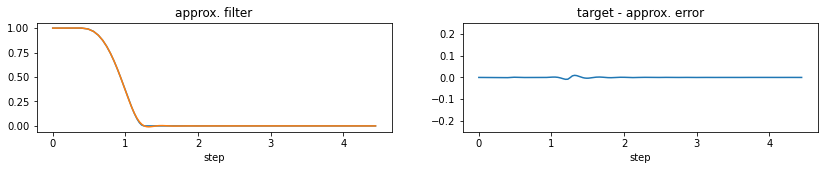

Taper, # Laplacian steps: 34; # Biharmonic steps: 3


In [9]:
filter_fac = 5
Lf_g = filter_fac/np.sqrt(6) 
N_g=20
NL_g, sL_g, NB_g, sB_g = filterSpec(N_g, 1, Lf_g, 1, 'Gaussian', X=np.pi)
print('Gaussian, # Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))
Lf_t = filter_fac/2
N_t=40
NL_t, sL_t, NB_t, sB_t = filterSpec(N_t, 1, Lf_t, 1, 'Taper', X=np.pi)
print('Taper, # Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [28]:
select_index = 8040  # Jan 6 2015
test = ds['ugos'][select_index].data
test = test[None, :, :]
Nx = len(test[0, 1, :])
Ny = len(test[0, :, 1])
landMask = 0*np.random.randint(0,2,(Nx,Ny))
landMask[np.isnan(np.transpose(test[0, :, :]))] = 1
landMask[np.transpose(test[0, :, :] == 0)] = 1
landMask = np.transpose(landMask)

In [105]:
# dimensions 
# 1440 = lon
# 720 = lat
# need 1440 x 720 (dx is a 1D array, same size as 2nd dimension of field)

In [29]:
# FILTER
# dy = 1852*60*(ds['latitude'][2].data - ds['latitude'][1].data)
# dx = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data)
dx = np.ones(len(ds['latitude']))
dy = 1
u_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, np.transpose(ds['ugos'][select_index].data)[None, :, :], dx, dy)
v_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, np.transpose(ds['vgos'][select_index].data)[None, :, :], dx, dy)
u_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, np.transpose(ds['ugos'][select_index].data)[None, :, :], dx, dy)
v_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, np.transpose(ds['vgos'][select_index].data)[None, :, :], dx, dy)

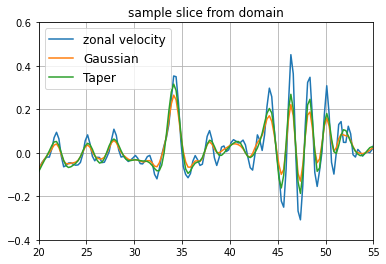

In [31]:
f, ax = plt.subplots()
ax.plot(ds['latitude'].data, ds['ugos'][select_index][:, 1300], label='zonal velocity')
ax.plot(ds['latitude'].data, u_filtG[0, 1300, :], label='Gaussian')
ax.plot(ds['latitude'].data, u_filtS[0, 1300, :], label='Taper')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12, loc='upper left')
ax.set_title('sample slice from domain')
ax.set_xlim([20,55])
ax.set_ylim([-0.4, 0.6])
ax.grid()
plt.show()

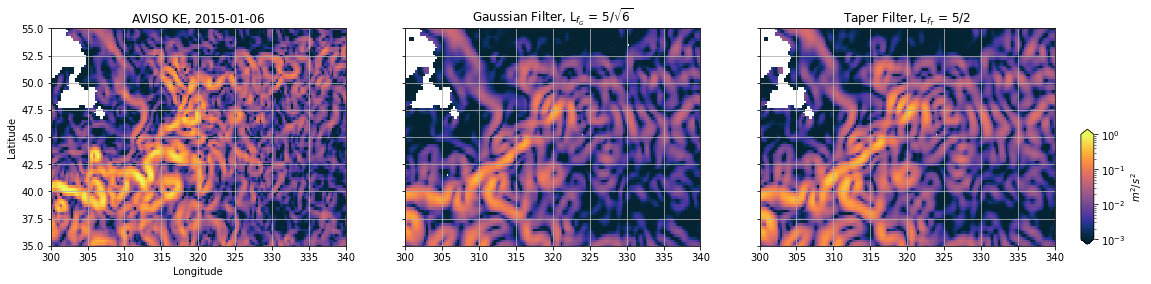

In [45]:
ke_filtG = np.transpose(0.5*(u_filtG[0, :, :]**2 + v_filtG[0, :, :]**2))
ke_filtG[landMask > 0] = np.nan
ke_filtS = np.transpose(0.5*(u_filtS[0, :, :]**2 + v_filtS[0, :, :]**2))
ke_filtS[landMask > 0] = np.nan

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=True)
axp = ax1.pcolor(ds['longitude'], ds['latitude'], 0.5*(ds['ugos'][1]**2 + ds['vgos'][1]**2), \
                 norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
ax2.pcolor(ds['longitude'], ds['latitude'], ke_filtG, norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
ax3.pcolor(ds['longitude'], ds['latitude'], ke_filtS, norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
this_time = str(ds['time'][8040].data)
ax1.set_title('AVISO KE, ' + this_time[0:10])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax2.set_title(r'Gaussian Filter, L$_{f_G}$ = 5/$\sqrt{6}$')
ax3.set_title(r'Taper Filter, L$_{f_T}$ = 5/2')
ax1.set_xlim([300, 340])
ax1.set_ylim([35, 55])
cbpos = [0.92, 0.13, 0.01, 0.4]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='$m^2/s^2$')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()
f.savefig('aviso_filtered_velocity.jpg', dpi=400)